In [46]:
%matplotlib inline 
import torch 
from IPython import display 
from matplotlib import pyplot as plt 
import numpy as np 
import random
from include.d2l_pytorch import *

### 生成数据集

In [47]:
num_inputs = 2;
num_examples = 1000;
true_w = [2, -3.4] 
true_b = 4.2
features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[ : , 0] + true_w[1] * features[ : , 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size()))

In [48]:
print(features[0], labels[0])

tensor([ 1.4398, -1.4104]) tensor(11.8852)


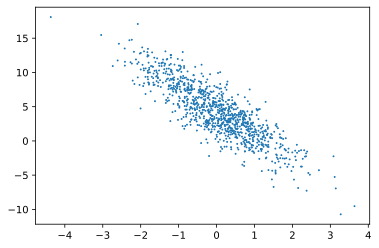

In [49]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

In [50]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels): 
    print(X, y) 
    break

tensor([[-0.1986, -0.3354],
        [-0.8263,  0.7967],
        [-0.2107,  1.1856],
        [ 0.3551,  1.7935],
        [-0.6051, -0.7633],
        [-0.2256,  0.9598],
        [ 1.0405,  1.7558],
        [-0.6885,  1.0657],
        [ 0.2659,  0.5792],
        [-0.0116, -0.3289]]) tensor([ 4.9425, -0.1608, -0.2415, -1.1740,  5.5728,  0.4901,  0.2935, -0.8146,
         2.7484,  5.2965])


In [51]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float64) 
b = torch.zeros(1, dtype=torch.float64)

In [52]:
w.requires_grad_(requires_grad=True) 
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [53]:
def linreg(X, w, b):  
    return torch.mm(X, w) + b
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def sgd(params, lr, batch_size): 
    for param in params: 
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

In [54]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w,b], lr, batch_size)
        
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_1 = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_1.mean().item()))

epoch 1, loss 0.031176
epoch 2, loss 0.000107
epoch 3, loss 0.000050


In [55]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9994],
        [-3.4002]], requires_grad=True)
4.2 
 tensor([4.2001], requires_grad=True)


# 3.3 线性回归简洁实现

In [56]:
num_inputs = 2;
num_examples = 1000;
true_w = [2, -3.4] 
true_b = 4.2
torch.set_default_tensor_type(torch.DoubleTensor)
features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[ : , 0] + true_w[1] * features[ : , 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size()))

In [57]:
import torch.utils.data as Data

batch_size = 10
dataset = Data.TensorDataset(features, labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

for X, y in data_iter:
    print(X, y)
    break

tensor([[ 0.1443, -1.2911],
        [-0.0828,  1.9488],
        [ 0.4464,  1.0203],
        [-0.6210,  1.2706],
        [-0.2361,  0.0588],
        [-0.4452, -0.7612],
        [ 1.6936,  0.6046],
        [-1.0612,  0.9094],
        [ 0.7884, -0.6553],
        [-0.4164,  1.4589]]) tensor([ 8.8789, -2.5911,  1.6229, -1.3711,  3.5462,  5.9100,  5.5219, -1.0036,
         8.0039, -1.5837])


In [58]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)

    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

In [59]:
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [60]:
# 使用nn.Seqyebtial
# 写法一
# net = nn.Sequential(nn.Linear(num_inputs, 1))

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))

# 写法三
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([('linear', nn.Linear(num_inputs, 1))]))
print(net)
print(net[0])


Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [61]:
# 初始化模型参数
from torch.nn import init  

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)

# 定义损失函数
loss = nn.MSELoss()

# 定义优化算法
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [62]:
# 训练模型
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))


epoch 1, loss: 9.748420
epoch 2, loss: 3.764745
epoch 3, loss: 1.218055
